## REINFORCE algorithm
----------------------------------------------------------------------------------------------------
Three key features of any RL algorithm:
1. Policy: $\pi_\theta$ = Probablities of all actions, given a state. Parameterized by $\theta$.  
2. Objective function: $ \max_\limits{\theta} J(\pi_{\theta}) = \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} [R(\tau)]$
3. Method: Way to udate the parameters = Policy Gradient

Policy gradient numerical computation
- Plain vanilla: $\nabla_\theta J(\theta)  = \mathbb{E}_{\tau \sim \pi_\theta} \; [ \; \sum_{t=0}^T R_t(\tau) \; \nabla_\theta \ln \pi_\theta(a_t \vert s_t) \;]$
- With Monte Carlo sampling and approximation: $\nabla_\theta J(\theta) \approx [ \; \sum_{t=0}^T R_t(\tau) \; \nabla_\theta \ln \pi_\theta(a_t \vert s_t) \;]$

- With baseline: $\nabla_\theta J(\theta) \approx [ \; \sum_{t=0}^T (R_t(\tau) - b(s_t)) \; \nabla_\theta \ln \pi_\theta(a_t \vert s_t) \;]$
- Where, baseline does not change per time-step, it is for the entire trajectory
- One baseline option: $V^\pi$ - leads to Actor-Critic algorithm
- Simpler option: Average returns over trajectory: $b = \frac{1}{T}\sum_{t=0}^T R_t(\tau) $

### Algorithm:
1. Collect n episodes of data
2. At each timestep in an episode
    - Calculate the advantage of that timestep
    - Multiply the advantage by the negative of the log probability of the action taken
3. Sum all the values above.
4. Calculate the gradient of this value with respect to all of the parameters of the network
5. Update the network parameters using the gradient

### Implementation notes:
- This version is L. Graesser (2020), as-is version
- REINFORCE_V2 notebook is modified 

In [1]:
import gym
import numpy as np
import torch

from torch.distributions import Categorical
import torch.nn as nn
import torch.optim as optim

from utilities import plot_learning_curve 

In [2]:
gamma = 0.99
alpha = 0.01
EPISODES = 300

### Network class - function approximator

In [3]:
class PolicyNetwork(nn.Module):
    
    # Step 1: Define the network architecture
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        
        # Define network
        layers = [
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        ]
    
    # Step 2: Feed-forward algo. PyTorch handles back-prop for us, but feed-forward we must provide
    def feed_forward(self, state):
        # Probability distribution (pd) parameters
        pdparam = self.model(state)
        return pdparam
    

### Policy class

In [4]:
class Policy_pi(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Policy_pi, self).__init__()
        
        # Define network
        layers = [
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        ]
        
        # Buld the network and this becomes our "model" 
        self.model = nn.Sequential(*layers) 
        
        # On-policy, so discard previous experiences. Empty buffer
        self.onpolicy_reset()
        
        # Call training loop
        self.train()
        
    def onpolicy_reset(self):
        self.log_probs = []
        self.rewards = []
        
    # x is actually the state
    def forward(self, x):
        # Probability distribution (pd) parameters
        pdparam = self.model(x)
        return pdparam        
    
    def act(self, state):
        x = torch.from_numpy(state.astype(np.float32)) # Convert to tensor
        pdparam = self.forward(x) # forward pass
        pd = Categorical(logits=pdparam) # probability distribution
        action = pd.sample() # pi(a|s) in action via pd
        log_prob = pd.log_prob(action) # log prob of pi(a|s)
        self.log_probs.append(log_prob) # store for training
        return (action.item())
    
    

In [5]:
def train(policy, optimizer):
        # Inner gradient-ascent loop
        T = len(policy.rewards) # Length of a trajectory
        returns = np.empty(T, dtype=np.float32)
        future_returns = 0.0

        # Compute returns
        for t in reversed(range(T)):
            future_returns = policy.rewards[t] + gamma*future_returns
            returns[t] = future_returns

        returns = torch.tensor(returns)
        log_probs = torch.stack(policy.log_probs)
        loss = log_probs*returns # Compute gradient term. Negative for maximizing 
        loss = torch.sum(loss)
        optimizer.zero_grad()
        loss.backward() # backpropogate and compute gradients
        optimizer.step() # gradient ascent, update the weights
        return (loss)

### Main loop

4 2
0: Loss: -70.45 | Total reward: 014.00 | Solved: False
100: Loss: -02.31 | Total reward: 008.00 | Solved: False
200: Loss: -00.07 | Total reward: 008.00 | Solved: False


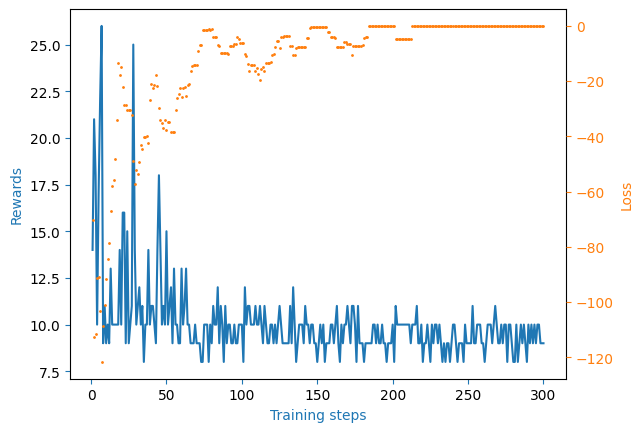

<Figure size 1000x400 with 0 Axes>

In [6]:
rewards_history = []
loss_history = []

env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
print(input_dim, output_dim)
policy_pi = Policy_pi(input_dim, output_dim)
optimizer = optim.Adam(policy_pi.parameters(), lr=alpha)

for episode in range(EPISODES):
    state = env.reset()
    
    # Sample a trajectory. 
    for t in range(200): # Max. time-steps for CartPole is 200
        action = policy_pi.act(state)
        state, reward, done, _ = env.step(action)
        policy_pi.rewards.append(reward)
        #env.render()
        if done:
            break
        
    loss = train(policy_pi, optimizer) # train per episode
    total_reward = sum(policy_pi.rewards)
    
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting
    
    solved = total_reward > 195.0
    policy_pi.onpolicy_reset()

    if (episode%100 ==0):
        print(f'{episode}: Loss: {loss:06.2f} | Total reward: {total_reward:06.2f} | Solved: {solved}')

env.close()

x = [i+1 for i in range(EPISODES)]
plot_learning_curve(x, rewards_history=rewards_history, loss_history=loss_history, 
                    moving_avg_n=10, filename='CartPole_REINFORCE.png') 